## 範例重點
* 學習如何在 keras 中加入 BatchNorm
* 知道有無 BN 對訓練的影響
* 比較 BN 在不同 batch size 下的效果

In [2]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
#put BN after input layer
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    input_layer = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
#put BN before activity layer
def build_mlp3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE =  [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [10]:
results = {}

for batchs in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    #optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batchs, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "1_batch-%s" % str(batchs)
    results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

W0725 10:20:41.459105 4446897600 deprecation_wrapper.py:119] From /Users/vincent/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 10:20:41.477333 4446897600 deprecation_wrapper.py:119] From /Users/vincent/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 10:20:41.481670 4446897600 deprecation_wrapper.py:119] From /Users/vincent/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 10:20:41.552635 4446897600 deprecation_wrapper.py:119] From /Users/vincent/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_defa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 228s 5ms/step - loss: 2.1990 - acc: 0.1875 - val_loss: 2.4732 - val_acc: 0.2734
Epoch 50/50
50000/50000 [==============================] - 228s 5ms/step - loss: 2.1937 - acc: 0.1916 - val_loss: 2.5431 - val_acc: 0.2568
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
________

Epoch 48/50
50000/50000 [==============================] - 51s 1ms/step - loss: 1.1506 - acc: 0.5934 - val_loss: 1.3477 - val_acc: 0.5287
Epoch 49/50
50000/50000 [==============================] - 51s 1ms/step - loss: 1.1535 - acc: 0.5896 - val_loss: 1.3894 - val_acc: 0.5111
Epoch 50/50
50000/50000 [==============================] - 50s 1ms/step - loss: 1.1524 - acc: 0.5936 - val_loss: 1.4007 - val_acc: 0.5075
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131

50000/50000 [==============================] - 29s 585us/step - loss: 0.8773 - acc: 0.6862 - val_loss: 1.5886 - val_acc: 0.5002
Epoch 47/50
50000/50000 [==============================] - 29s 583us/step - loss: 0.8676 - acc: 0.6908 - val_loss: 1.5871 - val_acc: 0.4850
Epoch 48/50
50000/50000 [==============================] - 29s 582us/step - loss: 0.8670 - acc: 0.6888 - val_loss: 1.5369 - val_acc: 0.5136
Epoch 49/50
50000/50000 [==============================] - 29s 584us/step - loss: 0.8618 - acc: 0.6932 - val_loss: 1.5328 - val_acc: 0.5050
Epoch 50/50
50000/50000 [==============================] - 29s 584us/step - loss: 0.8572 - acc: 0.6926 - val_loss: 1.6380 - val_acc: 0.4862
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)        

50000/50000 [==============================] - 10s 195us/step - loss: 0.4418 - acc: 0.8404 - val_loss: 2.2819 - val_acc: 0.4859
Epoch 45/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.4211 - acc: 0.8479 - val_loss: 2.2401 - val_acc: 0.4864
Epoch 46/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.4149 - acc: 0.8498 - val_loss: 2.1974 - val_acc: 0.5048
Epoch 47/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.4151 - acc: 0.8496 - val_loss: 2.3103 - val_acc: 0.4974
Epoch 48/50
50000/50000 [==============================] - 10s 197us/step - loss: 0.4024 - acc: 0.8546 - val_loss: 2.3119 - val_acc: 0.4897
Epoch 49/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.3975 - acc: 0.8579 - val_loss: 2.3190 - val_acc: 0.4924
Epoch 50/50
50000/50000 [==============================] - 10s 197us/step - loss: 0.3870 - acc: 0.8609 - val_loss: 2.3392 - val_acc: 0.4856
________________________________

50000/50000 [==============================] - 6s 120us/step - loss: 0.3061 - acc: 0.8906 - val_loss: 2.4820 - val_acc: 0.4865
Epoch 43/50
50000/50000 [==============================] - 6s 121us/step - loss: 0.2906 - acc: 0.8963 - val_loss: 3.1624 - val_acc: 0.4264
Epoch 44/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.2766 - acc: 0.9011 - val_loss: 2.5692 - val_acc: 0.4718
Epoch 45/50
50000/50000 [==============================] - 6s 121us/step - loss: 0.2691 - acc: 0.9043 - val_loss: 2.6451 - val_acc: 0.4752
Epoch 46/50
50000/50000 [==============================] - 6s 121us/step - loss: 0.2651 - acc: 0.9053 - val_loss: 2.8322 - val_acc: 0.4463
Epoch 47/50
50000/50000 [==============================] - 6s 121us/step - loss: 0.2686 - acc: 0.9027 - val_loss: 3.0068 - val_acc: 0.4583
Epoch 48/50
50000/50000 [==============================] - 6s 121us/step - loss: 0.2512 - acc: 0.9107 - val_loss: 2.8107 - val_acc: 0.4662
Epoch 49/50
50000/50000 [==============

In [12]:
for batchs in BATCH_SIZE:
    model = build_mlp3(input_shape=x_train.shape[1:])
    model.summary()
    #optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batchs, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "3_batch-%s" % str(batchs)
    results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total para

50000/50000 [==============================] - 227s 5ms/step - loss: 2.1463 - acc: 0.2126 - val_loss: 2.5309 - val_acc: 0.2866
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_______________

Epoch 50/50
50000/50000 [==============================] - 47s 936us/step - loss: 1.0603 - acc: 0.6180 - val_loss: 1.3710 - val_acc: 0.5322
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__

50000/50000 [==============================] - 28s 553us/step - loss: 0.7907 - acc: 0.7138 - val_loss: 1.5972 - val_acc: 0.5114
Epoch 50/50
50000/50000 [==============================] - 28s 556us/step - loss: 0.7794 - acc: 0.7183 - val_loss: 1.6795 - val_acc: 0.4929
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_30 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
______

50000/50000 [==============================] - 10s 193us/step - loss: 0.3632 - acc: 0.8681 - val_loss: 2.5989 - val_acc: 0.4785
Epoch 49/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.3499 - acc: 0.8733 - val_loss: 2.4950 - val_acc: 0.4950
Epoch 50/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.3519 - acc: 0.8728 - val_loss: 2.6564 - val_acc: 0.4638
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_33 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328   

50000/50000 [==============================] - 6s 120us/step - loss: 0.2482 - acc: 0.9110 - val_loss: 2.6723 - val_acc: 0.4860
Epoch 48/50
50000/50000 [==============================] - 6s 118us/step - loss: 0.2377 - acc: 0.9159 - val_loss: 2.8698 - val_acc: 0.4605
Epoch 49/50
50000/50000 [==============================] - 6s 119us/step - loss: 0.2304 - acc: 0.9183 - val_loss: 2.7412 - val_acc: 0.4735
Epoch 50/50
50000/50000 [==============================] - 6s 118us/step - loss: 0.2293 - acc: 0.9198 - val_loss: 2.8447 - val_acc: 0.4751


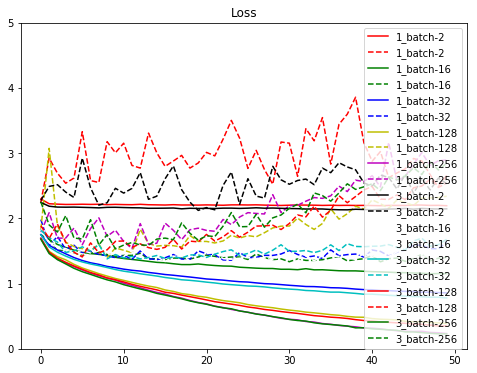

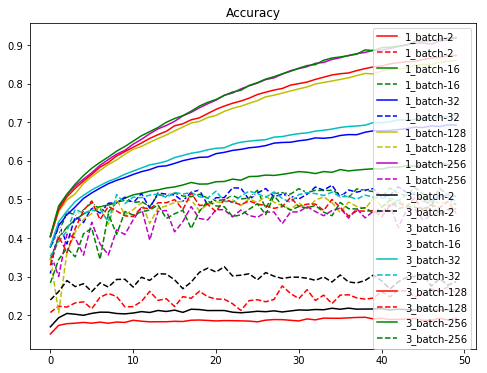

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","w","c"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i%8])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i%8])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
   all the 1_batch and 3_batch has the size
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果
    3_batch are the BN before activity function.
    And before the activity function is the same as after input layer. Since activity function is after that.